In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import csv
import os
from scipy.signal import butter, filtfilt
#from PyEMD import EMD
import emd
import time
import pywt
import biosppy.signals.ecg as bsp_ecg
import biosppy.signals.tools as bsp_tools

from scipy import signal

from utils import print_signal_qrs, print_signal, calcul_f1, perf

import numpy as np
from scipy.signal import butter, filtfilt
import pywt
import pandas as pd
import scipy
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import MinMaxScaler

In [14]:
T = 2440

def wavelet_decomposition_cut(sig, idx, fs, cut=512):
    print(len(sig))
    w5, w4, w3, w2, w1 = [], [], [], [], []
    
    num_iterations = len(sig) // cut
    
    for i in range(num_iterations):
        coeffs = pywt.wavedec(sig[i*cut:i*cut+cut], "haar", level=idx)
        w5.extend(coeffs[5])
        w4.extend(coeffs[4])
        w3.extend(coeffs[3])
        w2.extend(coeffs[2])
        w1.extend(coeffs[1])
        
    full_coeffs = [w1, w2, w3, w4, w5]
    
    for i in range(len(full_coeffs)):
        w_temp = full_coeffs[i]
        temp_usampled = upsample_signal(w_temp, len(sig))
        print_signal(np.abs(temp_usampled[:T]), f"wavelet {5-i}")
        
    w4 = full_coeffs[-2]
    w5 = full_coeffs[-1]
    
    w4_upsampled = upsample_signal(w4, len(sig))
    w5_upsampled = upsample_signal(w5, len(sig))

    
    resultat = np.abs(w4_upsampled * w5_upsampled)
    return resultat

signal de longueur: 2440


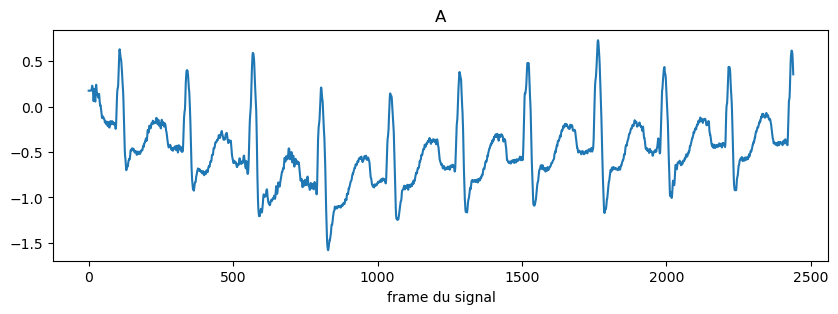

650000
signal de longueur: 2440


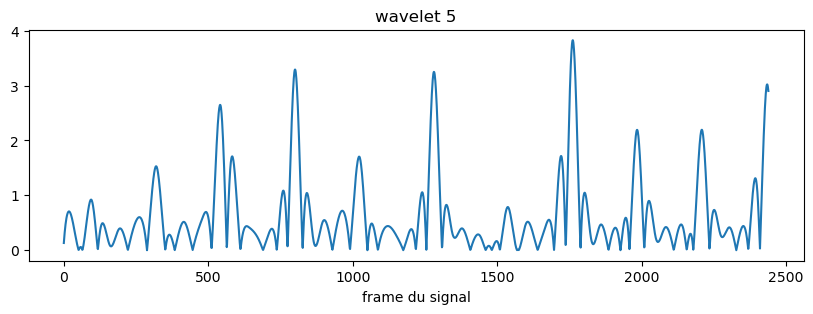

signal de longueur: 2440


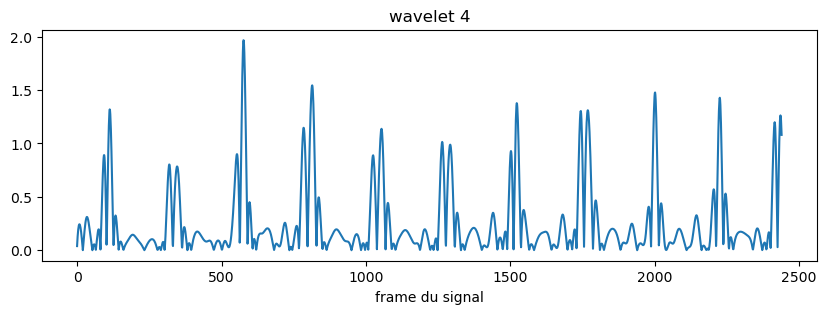

signal de longueur: 2440


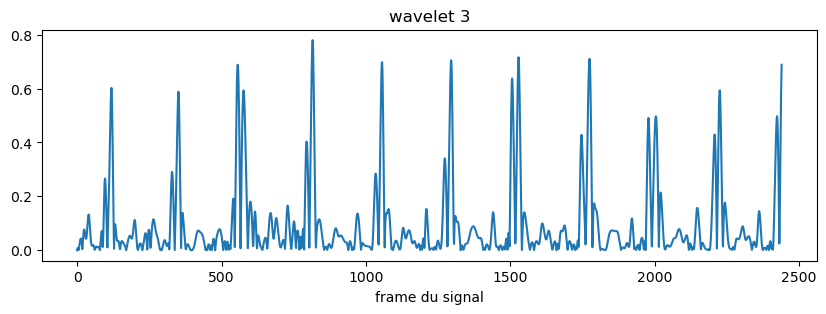

signal de longueur: 2440


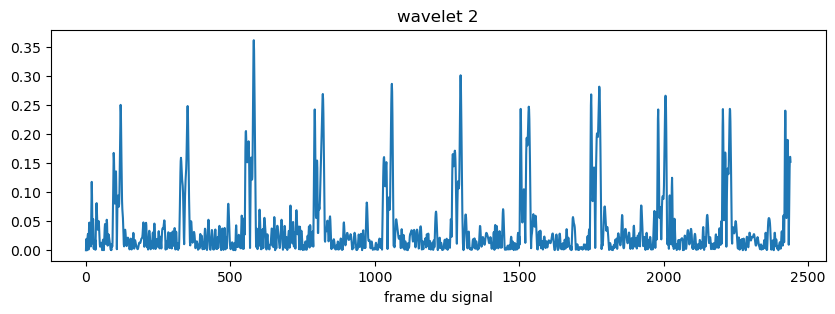

signal de longueur: 2440


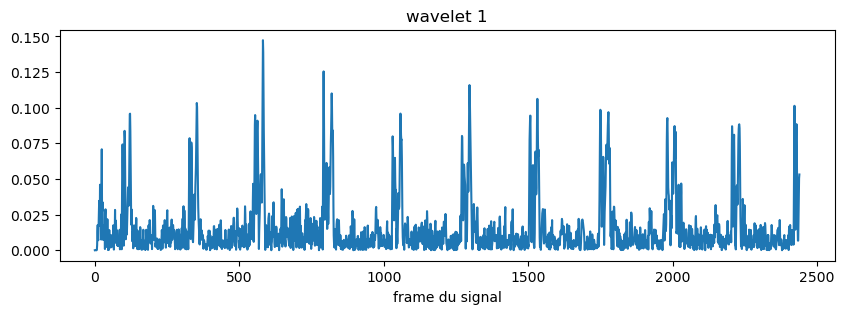

signal de longueur: 2440


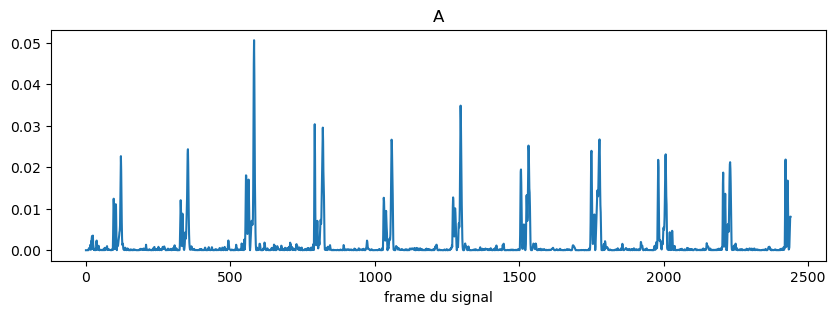

signal de longueur: 2440


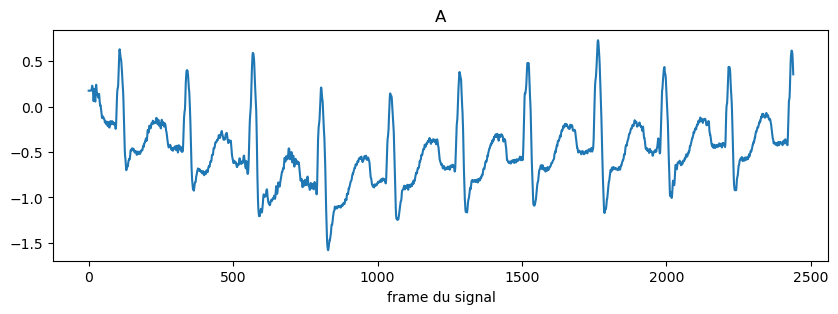

In [15]:
print_signal(ecg_signal[:T])

h2 = wavelet_decomposition_cut(ecg_signal, 5, sampling_rate)

print_signal(h2[:T])
print_signal(ecg_signal[:T])

In [6]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/109.csv')#[:20000] #207
mini = 0
maxi = len(df) #10000

ecg_signal = np.array(df["MLII"], dtype=np.float32)
sampling_rate = 360
QRS = df["labels"].dropna().tolist()

QRS = [int(R) for R in QRS if R <= maxi and R <= maxi]

In [26]:
T = 3600

def wavelet_decomposition(sig, idx, fs):
    print(len(sig))
    coeffs = pywt.wavedec(sig, "haar", level=idx)
    
    for i in range(1, len(coeffs)):
        w_temp = coeffs[i]
        temp_usampled = upsample_signal(w_temp, len(sig))
        print_signal(np.abs(temp_usampled[:T]), f"wavelet {6-i}")
        
    w4 = coeffs[-2]
    w5 = coeffs[-1]
    
    w4_upsampled = upsample_signal(w4, len(sig))
    w5_upsampled = upsample_signal(w5, len(sig))

    
    resultat = np.abs(w4_upsampled * w5_upsampled)
    return resultat

In [11]:
def upsample_signal(original_signal, upsampled_length):
    original_indices = np.linspace(0, len(original_signal) - 1, num=len(original_signal))
    upsampled_indices = np.linspace(0, len(original_signal) - 1, num=upsampled_length)
    cs = CubicSpline(original_indices, original_signal)
    upsampled_signal = cs(upsampled_indices)
    return upsampled_signal

signal de longueur: 3600


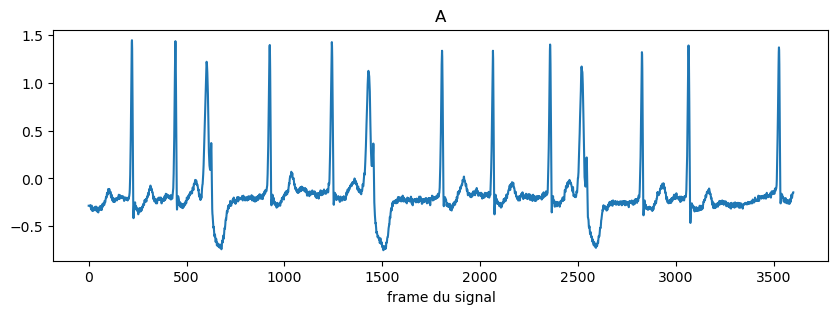

650000
signal de longueur: 3600


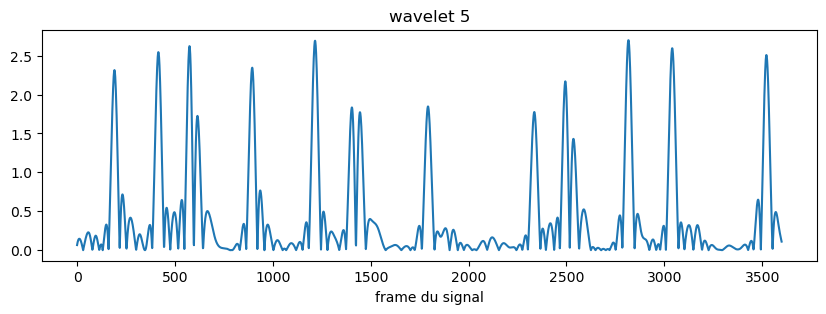

signal de longueur: 3600


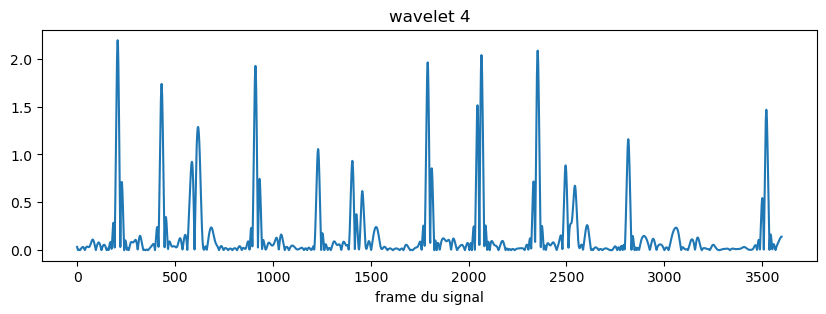

signal de longueur: 3600


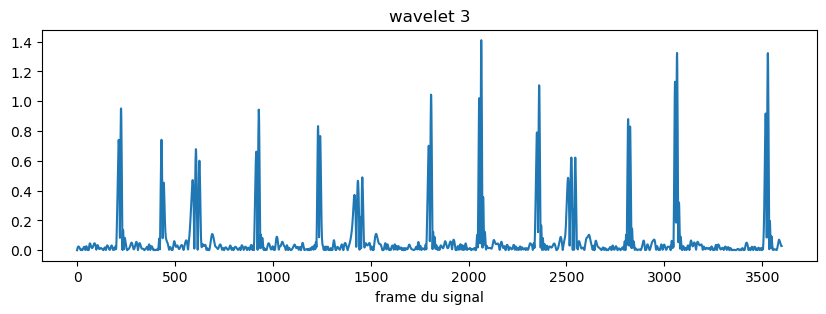

signal de longueur: 3600


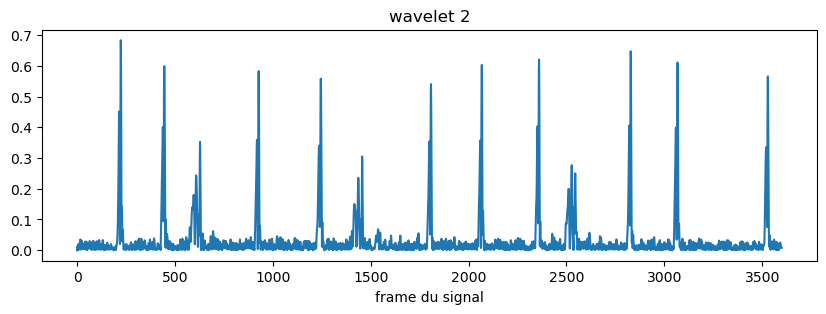

signal de longueur: 3600


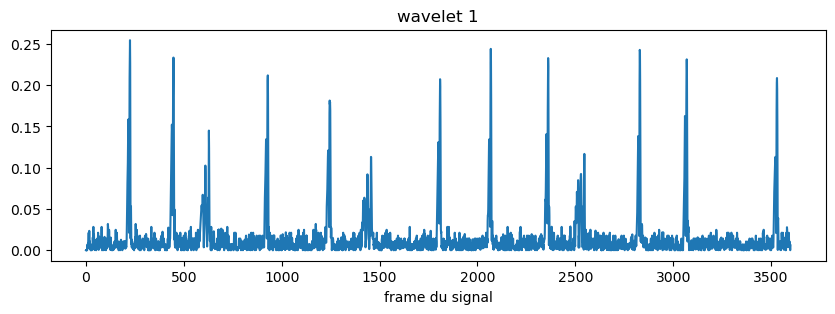

signal de longueur: 3600


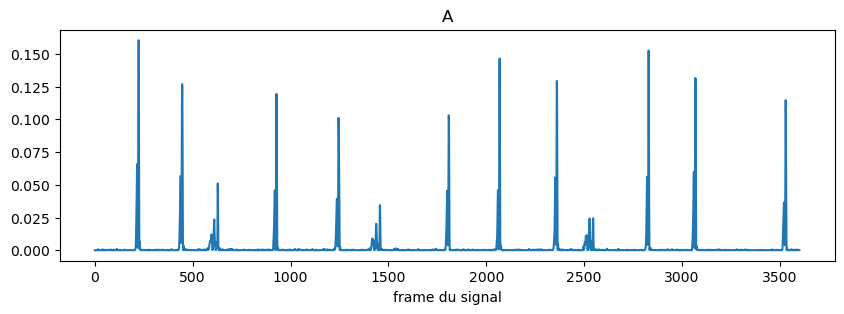

In [20]:
print_signal(ecg_signal[:T])

h2 = wavelet_decomposition(ecg_signal, 5, sampling_rate)

print_signal(h2[:T])

In [21]:
def wavelet_decomposition(sig, idx, nb_wave=0):
    listos = pywt.wavedec(sig, "haar", level=idx)
    resultat = np.array(insert_zeros(listos[-1], 1))
    resultat = resultat[:len(sig)]
    for i in range(1, idx-nb_wave):
        f = listos[-(i+1)]
        for j in range(i+1):
            f = insert_zeros(f, 1)
        f = f[:len(sig)]
        print_signal(f[:T], f"wavelet {i}")
        resultat = np.abs(np.multiply(resultat, np.array(f)))
    return resultat[15:]

def insert_zeros(lst, x):
    arr = np.array(lst)
    result = np.zeros(len(arr) + (len(arr) - 1) * x, dtype=arr.dtype)
    result[::x + 1] = arr
    result = np.append(result, 0)
    return result.tolist()

signal de longueur: 3600


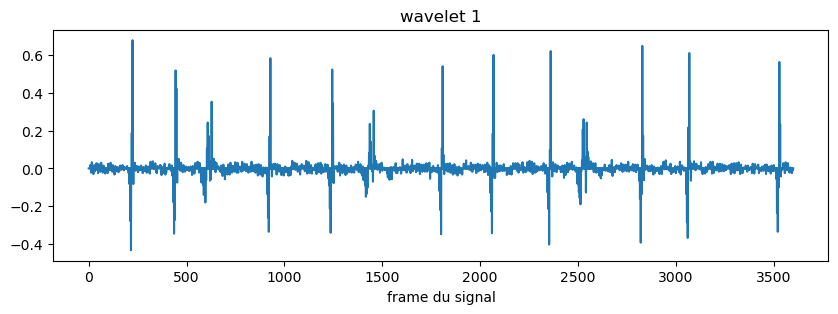

signal de longueur: 3600


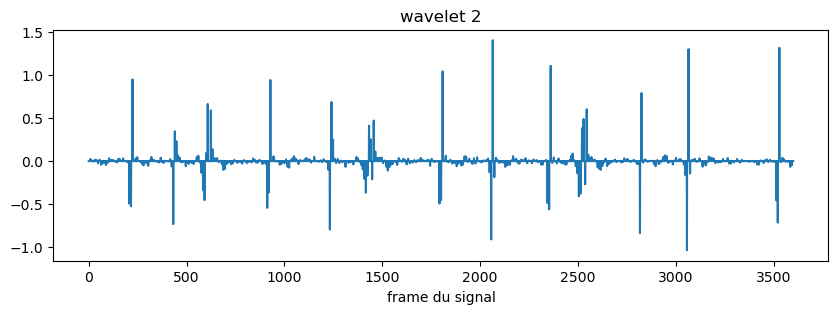

signal de longueur: 3600


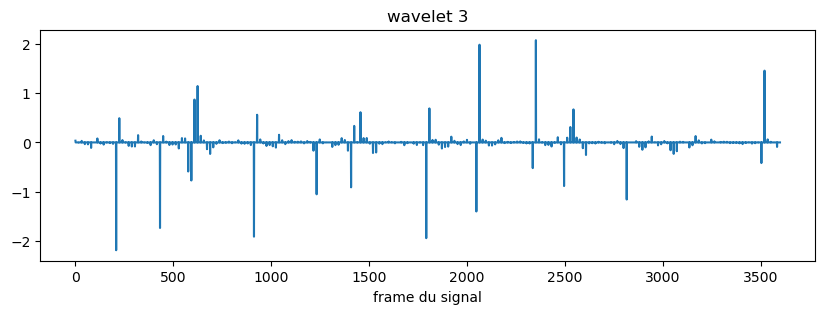

signal de longueur: 3600


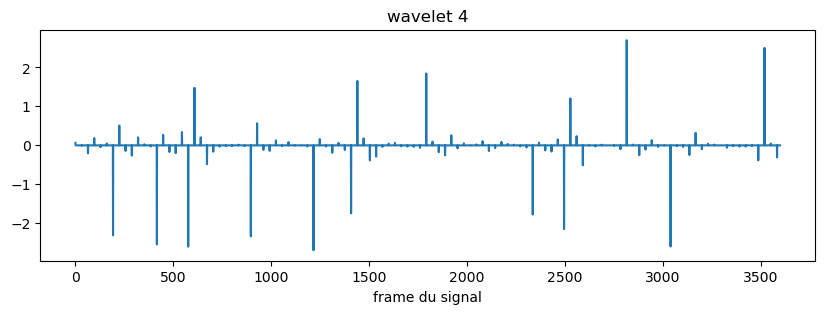

signal de longueur: 3600


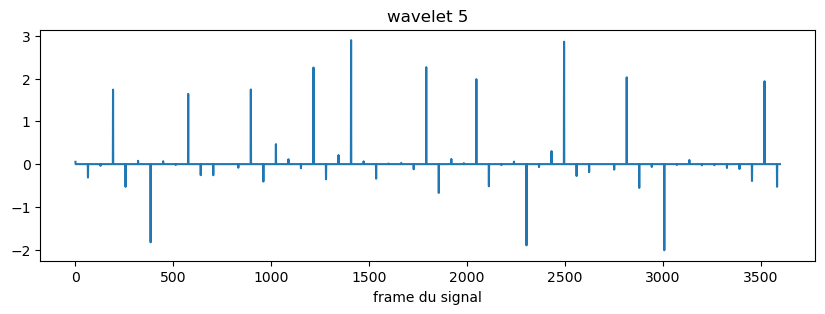

In [13]:
h = wavelet_decomposition(ecg_signal, 6)

In [222]:
def qrs_localization_wave(h, XX, fs):
    qrs_indices = []
    sous_groupe = []
    w = 1000
    threshold = XX * max(h[:w])
    for i in range(len(h)):
        if i%w == 0 and i != 0:
            threshold = XX * max(h[i-(w//2):i+(w//2)])
        #print(h[i])
        if h[i] >= threshold:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= (fs//10): # 36 = valeur donnée dans l'article
            qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

qrs = np.array(qrs_localization_wave(h2, 0.15, sampling_rate)) #0.15


In [224]:
print("224, 446, 628, 928, 1245, 1456, 1808, 2068, 2360, 2546, 2829, 3068, 3529, 3802, 4132, 4492, 4843, 5096")
print(QRS[:10])

224, 446, 628, 928, 1245, 1456, 1808, 2068, 2360, 2546, 2829, 3068, 3529, 3802, 4132, 4492, 4843, 5096
[28, 220, 442, 603, 924, 1241, 1430, 1804, 2064, 2356]


In [65]:
qrs = np.array(qrs_localization_wave(h, 0.15, sampling_rate)) #0.15
qrs = delete_contraction(qrs, sampling_rate, sampling_rate//10)
qrs = qrs + searchback_missed_qrs(h, qrs, sampling_rate)
qrs = delete_contraction(qrs, sampling_rate, sampling_rate//10)
qrs = delete_stat(qrs, sampling_rate)

TypeError: 'NoneType' object is not subscriptable

In [206]:
h = wavelet_decomposition(signal, 5, 3)
#h = [min(0.1, x) for x in h]
qrs = np.array(qrs_localization(h, 0.3, sampling_rate))
missed = searchback_missed_qrs(h, qrs, sampling_rate)
#r_peaks = qrs + missed

ValueError: operands could not be broadcast together with shapes (2244,) (122742,) 

In [208]:
perf(QRS, qrs, 36)

(596,
 1649,
 1786,
 [array([9]),
  array([312]),
  array([372]),
  array([664]),
  array([835]),
  array([948]),
  array([1078]),
  array([1232]),
  array([1516]),
  array([1588]),
  array([2040]),
  array([2342]),
  array([2404]),
  array([2593]),
  array([2708]),
  array([3000]),
  array([3111]),
  array([3284]),
  array([3357]),
  array([3556]),
  array([4092]),
  array([4172]),
  array([4468]),
  array([4637]),
  array([4768]),
  array([4889]),
  array([5056]),
  array([5348]),
  array([5409]),
  array([5920]),
  array([6160]),
  array([6216]),
  array([6408]),
  array([6528]),
  array([6820]),
  array([6939]),
  array([7108]),
  array([7191]),
  array([7396]),
  array([8248]),
  array([8437]),
  array([8540]),
  array([8694]),
  array([8840]),
  array([9144]),
  array([9215]),
  array([9712]),
  array([9949]),
  array([10000]),
  array([10196]),
  array([10284]),
  array([10592]),
  array([10689]),
  array([10896]),
  array([10939]),
  array([11188]),
  array([11699]),
  array([1

In [3]:
def wavelet_decomposition(sig, idx, nb_wave):
    listos = pywt.wavedec(sig, "haar", level=idx)
    resultat = np.array(insert_zeros(listos[-1], 1))
    resultat = resultat[:len(sig)]
    for i in range(1, idx-nb_wave):
        f = listos[-(i+1)]
        for j in range(i+1):
            f = insert_zeros(f, 1)
        f = f[:len(sig)]
        resultat = np.abs(np.multiply(resultat, np.array(f)))
    return resultat

def insert_zeros(lst, x):
    arr = np.array(lst)
    result = np.zeros(len(arr) + (len(arr) - 1) * x, dtype=arr.dtype)
    result[::x + 1] = arr
    result = np.append(result, 0)
    return result.tolist()

def qrs_localization(h, XX, fs):
    qrs_indices = []
    sous_groupe = []
    w = 1000
    threshold = XX * max(h[:w])
    A = int(fs//10)
    compteur = 0
    for i in range(len(h)):
        if compteur != 0:
            compteur -= 1
            continue
        if i%w == 0 and i != 0:
            threshold = XX * max(h[i-(w//2):i+(w//2)])
        if h[i] >= threshold:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= A: # 36 = valeur donnée dans l'article
            v = max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0]
            qrs_indices.append(v)
            compteur = A * 2 - (i - v)
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

def qrs_localization_normal(h, seuil):
    qrs_indices = []
    sous_groupe = []
    for i in range(len(h)):
        if h[i] >= seuil:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= 36: # 36 = valeur donnée dans l'article
            qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

def delete_contraction(r_peaks, fs):
    new_r_peaks = []
    i = 0
    T = 0.2 * fs # 200ms
    while i < len(r_peaks) -1:
        new_r_peaks.append(r_peaks[i])
        if r_peaks[i] + T >= r_peaks[i+1] : # 5 * (fs / 2 )200 correspond à un mouvement du coeur particulier après un battement
            i += 2
        else:
            i += 1
    return new_r_peaks
            
def searchback_missed_qrs(ecg_signal, filtered_indices, fs):
    rr_interval = np.diff(filtered_indices)
    #search_interval = int(v * np.mean(rr_interval))
    missed_peaks = []
    w = int(fs*0.2)
    for i in range(1, len(filtered_indices) - 1):
        if filtered_indices[i+1] - filtered_indices[i] > rr_interval[i-1] * 1.5:
            intervening_segment = ecg_signal[filtered_indices[i]+w:filtered_indices[i+1]-w]
            #a = qrs_localization_normal(ecg_signal, (max(ecg_signal)*0.3*0.5)
            a = qrs_localization(ecg_signal, 0.15, fs)
            missed_peaks.extend([filtered_indices[i] + x for x in a])
    return missed_peaks

In [186]:
def wavelet_decomposition(sig, idx, nb_wave):
    listos = pywt.wavedec(sig, "haar", level=idx)
    resultat = np.array(insert_zeros(listos[-1], 1))
    resultat = resultat[:len(sig)]
    for i in range(1, idx-nb_wave):
        f = listos[-(i+1)]
        for j in range(i+1):
            f = insert_zeros(f, 1)
        f = f[:len(sig)]
        resultat = np.abs(np.multiply(resultat, np.array(f)))
    return resultat

def insert_zeros(lst, x):
    arr = np.array(lst)
    result = np.zeros(len(arr) + (len(arr) - 1) * x, dtype=arr.dtype)
    result[::x + 1] = arr
    result = np.append(result, 0)
    return result.tolist()

def qrs_localization(h, XX, fs):
    qrs_indices = []
    sous_groupe = []
    w = 5000
    threshold = XX * max(h[:w])
    A = int(fs//10)
    compteur = 0
    for i in range(len(h)):
        if compteur != 0:
            compteur -= 1
            continue
        if i%w == 0 and i != 0:
            threshold = XX * max(h[i-(w//2):i+(w//2)])
        if h[i] >= threshold:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= A: # 36 = valeur donnée dans l'article
            v = max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0]
            qrs_indices.append(v)
            compteur = A # - (i - v)
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

def qrs_localization_normal(h, seuil):
    qrs_indices = []
    sous_groupe = []
    seuil = seuil * max(h)
    for i in range(len(h)):
        if h[i] >= seuil:
            sous_groupe.append(i)
        elif sous_groupe != [] and i - sous_groupe[-1] >= 36: # 36 = valeur donnée dans l'article
            qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
            sous_groupe = []
    if sous_groupe != []:
        qrs_indices.append(max([(x, h[x]) for x in sous_groupe], key=lambda x: x[1])[0])
    return qrs_indices

def delete_contraction(r_peaks, fs):
    new_r_peaks = []
    i = 0
    T = 0.2 * fs # 200ms
    while i < len(r_peaks) -1:
        new_r_peaks.append(r_peaks[i])
        if r_peaks[i] + T >= r_peaks[i+1] : # 5 * (fs / 2 )200 correspond à un mouvement du coeur particulier après un battement
            i += 2
        else:
            i += 1
    return new_r_peaks
            
def searchback_missed_qrs(ecg_signal, filtered_indices, fs):
    rr_interval = np.diff(filtered_indices)
    #search_interval = int(v * np.mean(rr_interval))
    missed_peaks = []
    w = int(fs*0.2)
    for i in range(1, len(filtered_indices) - 1):
        if filtered_indices[i+1] - filtered_indices[i] > rr_interval[i-1] * 1.5:
            intervening_segment = ecg_signal[filtered_indices[i]+w:filtered_indices[i+1]-w]
            #a = qrs_localization_normal(ecg_signal, (max(ecg_signal)*0.3*0.5)
            a = qrs_localization(ecg_signal, 0.3*0.5, fs)
            a = delete_contraction(a, fs)
            missed_peaks.extend([filtered_indices[i] + x for x in a])
    return missed_peaks

In [131]:
def print_signal(signal, description="a"):
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal)
    plt.axhline(y=(max(signal)*0.3), color='r', linestyle='-', label = "first")
    plt.axhline(y=(max(signal)*0.3)*0.5, color='g', linestyle='-', label = "second")
    #plt.scatter(QRS, [signal[i] for i in QRS], color='red')
    plt.title(label= description)
    plt.show()
    
def print_signal_qrs(signal, description, qrs):
    print(f"signal de longueur: {len(signal)}")
    plt.figure()
    plt.plot(signal)
    plt.scatter(qrs, [signal[i] for i in qrs], color='red')
    plt.title(label= description)
    plt.show()
    
def perf(labels, peaks, minmax):
    x = np.concatenate([np.array(labels), np.array(peaks)]) #list(set(QRS + r_peaks))
    x.sort()
    diff = x[1:]-x[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=minmax)])
    temp = [x[gps==i] for i in range(gps[-1]+1)]
    TP = 0
    FP = 0
    FN = 0
    list_F = []
    for sublist in temp:
        if len(sublist) == 2:
            TP += 1
        else:
            list_F.append(sublist)
            if sublist[0] in labels:
                FN += 1
            else:
                FP += 1
    return TP, FP, FN, list_F

In [7]:
def extend_list_with_averages(input_list):
    extended_list = [input_list[0]]
    length = len(input_list)

    for i in range(length - 1):
        current_element = input_list[i]
        next_element = input_list[i + 1]
        average = (current_element + next_element) / 2
        extended_list.append(average)
        extended_list.append(next_element)

    return extended_list

In [8]:
start = time.time()
performance = pd.DataFrame()
for fichier in os.listdir("data_csv/mit_bih_Arrhythmia/"):
    df = pd.read_csv(f'data_csv/mit_bih_Arrhythmia/{fichier}')
    if "MLII" not in df.columns:
        continue
    signal = np.array(df["MLII"], dtype=np.float32)
    sampling_rate = 360
    QRS = df["labels"].dropna().tolist()
    r_peaks = full_wavelets(signal)

    perf_temp = perf(QRS, r_peaks, 72)
    performance = pd.concat([performance, pd.DataFrame({"data" : fichier[:-4], "TP": perf_temp[0], "FP": perf_temp[1], "FN":perf_temp[2]}, index=[0])], ignore_index=True)
performance["Sensi"] = performance["TP"] / (performance["TP"] + performance["FN"])
performance["Specificity"] = performance["TP"] / (performance["TP"] + performance["FP"])
performance["f1_score"] = (2 * performance["TP"]) / (2 * performance["TP"] + performance["FN"] + performance["FP"])
performance.sort_values("f1_score", inplace = True)

print(f"f1_score = {np.mean(performance['f1_score'].tolist())} / Sensi = {np.mean(performance['Sensi'].tolist())} / Spec = {np.mean(performance['Specificity'].tolist())}")
end = time.time()
print(end - start)

NameError: name 'full_wavelets' is not defined

In [ ]:
def full_wavelets(signal):
    h = wavelet_decomposition(signal, 5)
    h = extend_list_with_averages(h)
    threshold = 0.3 * max(h)
    qrs = np.array(qrs_localization(h, threshold))
    qrs.sort()
    qrs = delete_contraction(qrs, sampling_rate)
    qrs = qrs + searchback_missed_qrs(h, qrs, 360)
    return qrs

In [65]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv') #207
signal = np.array(df["MLII"], dtype=np.float32)
sampling_rate = 360
maxi = len(df)
mini = 0
signal = signal[mini:maxi]
QRS = df["labels"].dropna().tolist()
QRS = [int(R) for R in QRS if R <= maxi and R <= maxi]

[    58    306    842 ... 649598 649794 649992]
signal de longueur: 649999


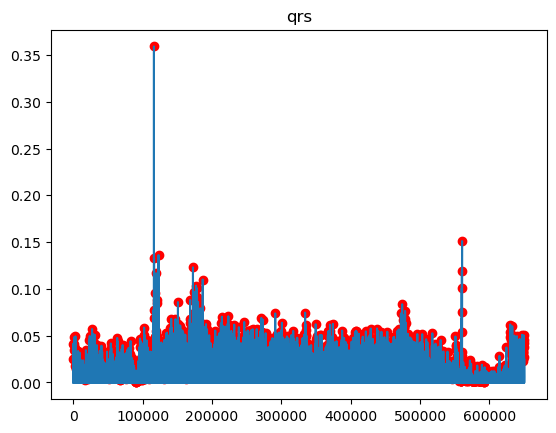

In [70]:
h = wavelet_decomposition(signal, 5)
#print_signal(d4, "wavelets")
#print_signal(d5, "wavelets")
h = extend_list_with_averages(h)
#print_signal(h, "PI")
threshold = 0.2 * max(h)
qrs = np.array(qrs_localization(h, threshold))
print(str(qrs))
qrs.sort()
qrs = delete_contraction(qrs, sampling_rate)
print_signal_qrs(h, "qrs", qrs)

In [73]:
perf(QRS, qrs, 36)
# 2087,  117,  249,

(2135,
 155,
 231,
 [array([9]),
  array([13868]),
  array([14414]),
  array([14754]),
  array([15118, 15138, 15162]),
  array([15759]),
  array([15798]),
  array([16138]),
  array([17346]),
  array([17406]),
  array([17470]),
  array([17618]),
  array([17658]),
  array([17730]),
  array([17788]),
  array([17857]),
  array([17914]),
  array([17976]),
  array([18068]),
  array([18132]),
  array([18350]),
  array([18396]),
  array([19715]),
  array([19760]),
  array([20168, 20183, 20218]),
  array([20962]),
  array([21056]),
  array([21092]),
  array([21731]),
  array([21827]),
  array([22262]),
  array([22774]),
  array([25627]),
  array([27256]),
  array([46025]),
  array([48133]),
  array([55103]),
  array([55775]),
  array([64967]),
  array([65681]),
  array([66375]),
  array([69978]),
  array([71340]),
  array([73494]),
  array([74943]),
  array([83557]),
  array([86540]),
  array([87172]),
  array([87214]),
  array([88202]),
  array([88259]),
  array([88716]),
  array([88788]),
  a

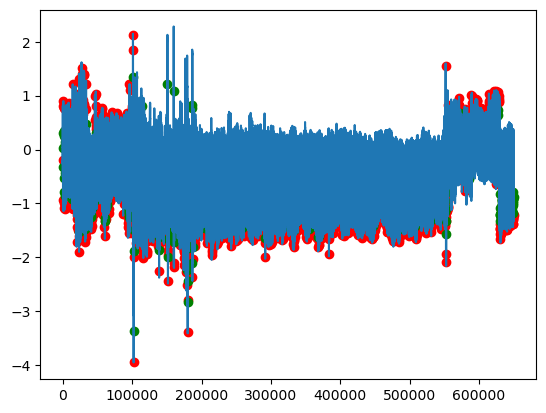

In [60]:
plt.figure()
plt.plot(signal[:maxi])
qrs = [x * 2 for x in qrs]
plt.scatter(QRS, [signal[i] for i in QRS], color='red', label = "label")
plt.scatter(qrs, [signal[i] for i in qrs], color='green', label = "predict")
plt.show()

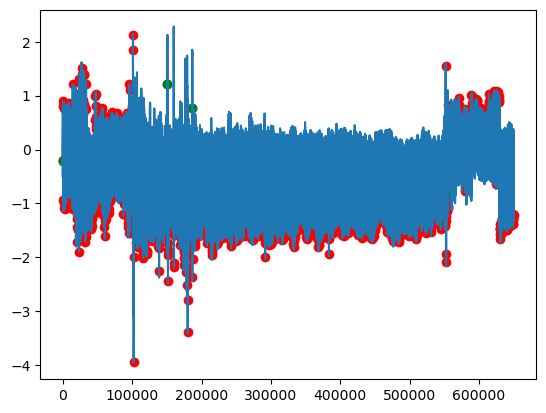

In [16]:
plt.figure()
plt.plot(signal[:maxi])
qrs = qrs*2
plt.scatter(QRS, [signal[i] for i in QRS], color='red', label = "label")
plt.scatter(qrs, [signal[i] for i in qrs], color='green', label = "predict")
plt.show()

In [67]:
def perf(labels, peaks, minmax):
    x = np.concatenate([np.array(labels), np.array(peaks)]) #list(set(QRS + r_peaks))
    x.sort()
    diff = x[1:]-x[:-1]
    gps = np.concatenate([[0], np.cumsum(diff>=minmax)])
    temp = [x[gps==i] for i in range(gps[-1]+1)]
    TP = 0
    FP = 0
    FN = 0
    list_F = []
    for sublist in temp:
        if len(sublist) == 2:
            TP += 1
        else:
            list_F.append(sublist)
            if sublist[0] in labels:
                FN += 1
            else:
                FP += 1
    return TP, FP, FN, list_F

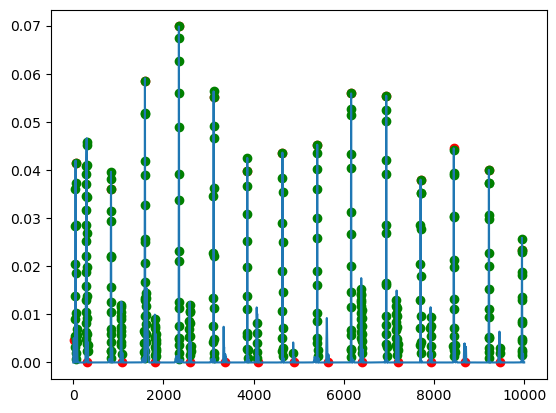

In [34]:
plt.figure()
plt.plot(filtered_signal[:max])
plt.scatter(QRS, [filtered_signal[i] for i in QRS], color='red')
plt.scatter(r_peaks, [filtered_signal[i] for i in r_peaks], color='green')
plt.show()